In [19]:
import foolbox as fb
import torch
import torchvision
from torchvision.models import ResNet18_Weights
from helpers import get_model
import numpy as np
import matplotlib.pyplot as plt
import eagerpy as ep
import copy
from torch.quantization import quantize_fx
import torchvision.transforms as transforms

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
testset = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=transform)


def load_test_data(data_dir):
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.RandomErasing()])
    trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
    testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)   
    return trainset, testset

data_dir = '../../data'
tra, tes = load_test_data(data_dir)
testloader = torch.utils.data.DataLoader(tes, batch_size=20, shuffle=False, num_workers=2)
dataloader = {"test": testloader}



save_path = '../../results/'
models_path = save_path

parameters = {  'num_classes': 10,
                'batch_size': 20, 
                'model_name':'Resnet18',
                'loss_function': 'Evidential',
                #'loss_function': 'Crossentropy',
                'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                'quantise':True}

if parameters['quantise'] == True:
    model_path = str(models_path)+str(parameters['loss_function'])+'_'+str(parameters['model_name'])+'_quant_model.pth'
else:
    model_path = str(models_path)+str(parameters['loss_function'])+'_'+str(parameters['model_name'])+'_model.pth'

model = get_model(parameters['model_name'],num_classes=parameters['num_classes'],weights=None)
if parameters['quantise'] == True:
    dataiter = iter(dataloader['test'])
    img, lab = next(dataiter)

    m = copy.deepcopy(model)
    m.to("cpu")
    m.eval()
    qconfig_dict = {"": torch.quantization.get_default_qconfig("fbgemm")}
    model_prepared = quantize_fx.prepare_fx(m, qconfig_dict, img)

    with torch.inference_mode():
        for _ in range(10):
            img, lab = next(dataiter)
            model_prepared(img)
    model = quantize_fx.convert_fx(model_prepared)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))) 

#model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)

model = model.eval()
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
bounds = (0, 1)
fmodel = fb.PyTorchModel(model, bounds=bounds, preprocessing=preprocessing)
fmodel = fmodel.transform_bounds((0, 1))
images, labels = fb.utils.samples(fmodel, dataset='cifar10', batchsize=16)
images = ep.astensor(images)
labels = ep.astensor(labels)

accuracy = fb.utils.accuracy(fmodel, images, labels)
print(accuracy)
#attack = fb.attacks.LinfDeepFoolAttack()
#attack = fb.attacks.LinfFastGradientAttack()
attack = fb.attacks.LinfProjectedGradientDescentAttack()
#attack = fb.attacks.SaltAndPepperNoiseAttack() 

# raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.03)
# accuracy = is_adv.float().mean().item()
# print(accuracy)


epsilons = np.linspace(0.0, 0.005, num=20)
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=epsilons)


robust_accuracy = 1 - is_adv.float32().mean(axis=-1)
print(robust_accuracy)
plt.plot(epsilons, robust_accuracy.numpy())
plt.savefig('robust_accuracy.png')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
0.5


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

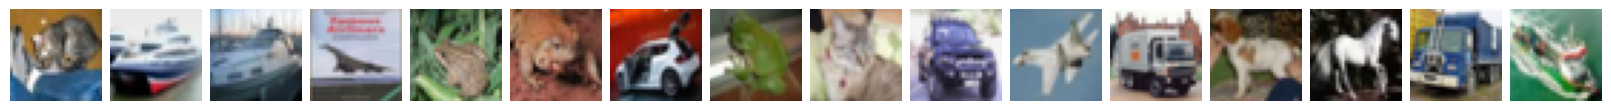

In [ ]:
fb.plot.images(images)
# fb.plot.images(raw)
# fb.plot.images(raw - images, n=4, bounds=(-0.1, 0.1), scale=4.)
